In [1]:
import numpy as np
import tensorflow as tf
import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-03-10 12:17:46.677761: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-10 12:17:46.677823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm, convert_to_linear_norm

## Load images

In [3]:
bands = [4,5,6,7,8,9]

######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

datalist = listdir_fullpath("/sps/lsst/users/bbiswas/simulations/COSMOS_btk/")

train_path = datalist[:800]
validation_path = datalist[800:]

# Take 1000 images from the first file.
images = np.load(validation_path[0], allow_pickle=True)

normalization_weights_path = '/sps/lsst/users/barcelin/data/blended_galaxies/' + '27.5/centered/test' 
print("Shape of loaded image" + str(np.shape(images)))

Shape of loaded image(484,)


## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [4]:
from debvader.normalize import LinearNormCosmos

In [5]:
isolated_images = images['isolated_gal_stamps']

Text(0.5, 1.0, 'difference')

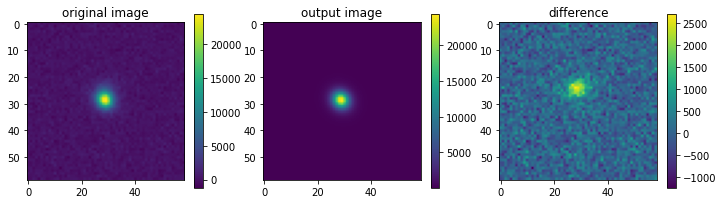

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 5

im = axs[0].imshow(images['blended_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images['blended_gal_stamps'][image_num][2, :, :] - images['isolated_gal_stamps'][image_num][2, :, :]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

In [7]:
images_isolated_normed = LinearNormCosmos().forward(np.array(np.array(images['isolated_gal_stamps'].tolist())))
images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = LinearNormCosmos().forward(np.array(np.array(images['blended_gal_stamps'].tolist())))
images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [8]:
flow_net = FlowVAEnet(latent_dim=32, linear_norm=True)
flow_net.load_flow_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/weights/fvae/')
flow_net.load_vae_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/weights/vae/val_loss/')
print(flow_net.vae_model.summary())

2022-03-10 12:18:00.539721: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-10 12:18:00.539830: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-10 12:18:00.539902: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-03-10 12:18:00.540551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 1

in cropping
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], even

2022-03-10 12:18:06.556718: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 32), (None, 32))  0         
_________________________________________________________________
decoder (Functional)         (None, 59, 59, 6)         4577196   
Total params: 8,318,420
Trainable params: 8,318,408
Non-trainable params: 12
_________________________________________________________________
None


## Test if VAE works

### Looking at image reconstruction

In [9]:
model_vae_output_isolated = flow_net.vae_model(images_isolated_normed)

2022-03-10 12:18:10.078252: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 80870592 exceeds 10% of free system memory.
2022-03-10 12:18:10.193419: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.
2022-03-10 12:18:10.412085: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.
2022-03-10 12:18:10.568408: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.
2022-03-10 12:18:10.630590: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.


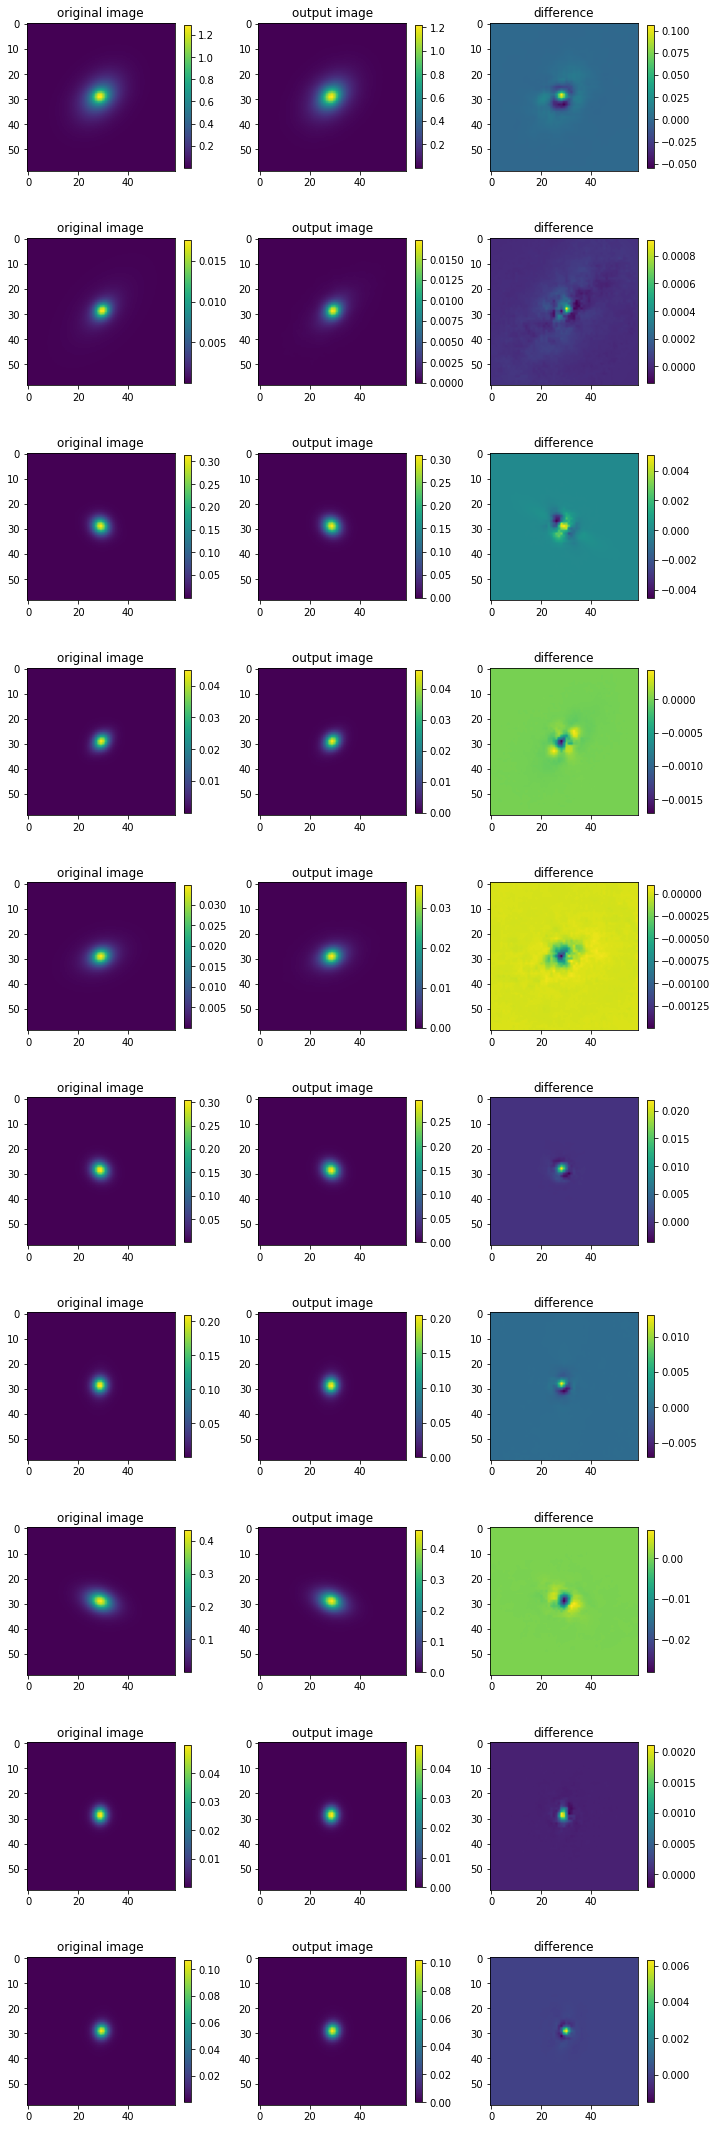

In [10]:
fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    image_num = i
    im = axs[i, 0].imshow(images_isolated_normed[image_num][:, :, 2])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("output image")


    difference = images_isolated_normed[image_num][:, :, 2] - model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [11]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=32)(flow_net.encoder(images_isolated_normed))

In [12]:
z.sample()

<tf.Tensor: shape=(484, 32), dtype=float32, numpy=
array([[ 3.22274303e+00, -1.18319380e+00, -3.55247259e+00, ...,
        -2.10474300e+00,  9.02783096e-01,  1.91946864e+00],
       [ 9.23350900e-02, -6.69033919e-03, -2.87352920e-01, ...,
         6.54383078e-02, -3.06921043e-02,  1.41184777e-01],
       [ 3.33073646e-01, -1.32122308e-01, -7.73967505e-01, ...,
        -1.14817195e-01, -1.09203835e-03,  4.82611388e-01],
       ...,
       [ 2.16645136e-01, -7.61805698e-02, -4.75532711e-01, ...,
        -1.17259420e-01,  1.27956823e-01,  2.10628688e-01],
       [ 6.95699990e-01, -2.54863948e-01, -8.83297622e-01, ...,
        -4.92057323e-01,  2.62775272e-01,  3.32029432e-01],
       [ 2.59378813e-02,  4.23127040e-02, -3.08128417e-01, ...,
         7.77998120e-02, -4.52057756e-02,  1.86049521e-01]], dtype=float32)>

In [13]:
z.covariance()

<tf.Tensor: shape=(484, 32, 32), dtype=float32, numpy=
array([[[ 1.00172239e-10, -4.54771538e-07,  1.75702709e-07, ...,
         -3.99744749e-07, -3.76482006e-07,  3.12423261e-08],
        [-4.54771538e-07,  2.06461549e-03, -7.97866553e-04, ...,
          1.81439391e-03,  1.70924782e-03, -1.41891287e-04],
        [ 1.75702709e-07, -7.97866553e-04,  6.84975879e-04, ...,
          8.37541666e-05, -7.74104206e-04,  1.60084965e-04],
        ...,
        [-3.99744749e-07,  1.81439391e-03,  8.37541666e-05, ...,
          1.66565832e-02,  3.47451540e-03,  2.28152191e-03],
        [-3.76482006e-07,  1.70924782e-03, -7.74104206e-04, ...,
          3.47451540e-03,  9.93149448e-03, -2.92604673e-04],
        [ 3.12423261e-08, -1.41891287e-04,  1.60084965e-04, ...,
          2.28152191e-03, -2.92604673e-04,  1.01745138e-02]],

       [[ 1.42940780e-05, -1.12334128e-05,  7.30169268e-06, ...,
          1.27491085e-05,  2.83251143e-06,  5.73274477e-08],
        [-1.12334128e-05,  3.28821261e-05,  5.39

## Test if flow network works

The likelihood should be higher for isolated galaxies:

In [14]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood

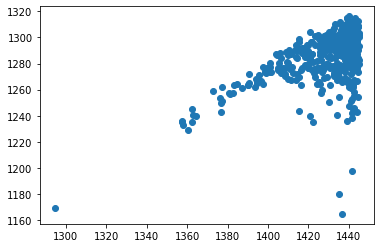

In [15]:
plt.scatter(isolated_likelihood, noisy_likelihood)

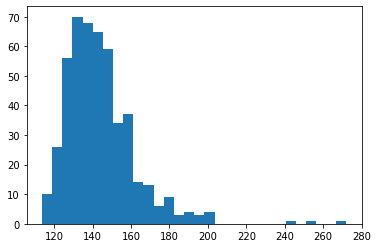

In [16]:
plt.hist(likelihood_difference.numpy(), bins=30)

This plot shows that we always observe the log prob of isolated galaxies to be higher than that of noisy/blended ones